## ANEXO 1: Limpieza y organización del DataFrame

In [ ]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

### Carga inicial

In [ ]:
# cargar dataframe principal
df_personas = pd.read_csv(r"..\data\personas\Microdato_Censo2017-Personas.csv", delimiter=";")

In [ ]:
# filtrar por mujeres entre 16 y 50 años, que tengan datos de escolaridad
df_full = df_personas[
    (df_personas["P08"]==2) &
    (df_personas["P09"] >= 16) &
    (df_personas["P09"] <= 50) &
    (df_personas["ESCOLARIDAD"] < 98)
]

In [ ]:
df_full.columns

Index(['REGION', 'PROVINCIA', 'COMUNA', 'DC', 'AREA', 'ZC_LOC', 'ID_ZONA_LOC',
       'NVIV', 'NHOGAR', 'PERSONAN', 'P07', 'P08', 'P09', 'P10', 'P10COMUNA',
       'P10PAIS', 'P11', 'P11COMUNA', 'P11PAIS', 'P12', 'P12COMUNA', 'P12PAIS',
       'P12A_LLEGADA', 'P12A_TRAMO', 'P13', 'P14', 'P15', 'P15A', 'P16',
       'P16A', 'P16A_OTRO', 'P17', 'P18', 'P19', 'P20', 'P21M', 'P21A',
       'P10PAIS_GRUPO', 'P11PAIS_GRUPO', 'P12PAIS_GRUPO', 'ESCOLARIDAD',
       'P16A_GRUPO', 'REGION_15R', 'PROVINCIA_15R', 'COMUNA_15R',
       'P10COMUNA_15R', 'P11COMUNA_15R', 'P12COMUNA_15R'],
      dtype='object')

### Importar información geográfica extra

In [ ]:
gdf = geopandas.read_file(r"..\data\geografia_extra\Distrito_Densid_Superficie.shp")

centroids = gdf.centroid
gdf["CENTROIDE_X_DIST"] = centroids.x
gdf["CENTROIDE_Y_DIST"] = centroids.y

In [ ]:
gdf["T_POB"] = gdf["T_POB"].astype(int)
gdf["COMUNA"] = gdf["COMUNA"].astype(int)
gdf = gdf[[
    "COMUNA", "COD_DISTRI",
    "T_POB", "SUPERFICIE", "Densidad",
    "CENTROIDE_X_DIST", "CENTROIDE_Y_DIST"
]].rename(columns={
    "T_POB": "POBLACION_DIST",
    "SUPERFICIE": "SUPERFICIE_DIST",
    "Densidad": "DENSIDAD_DIST"
})

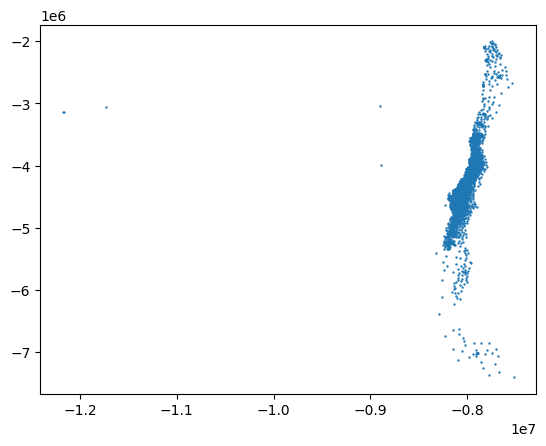

In [ ]:
# verificar buena carga de la información
plt.scatter(gdf["CENTROIDE_X_DIST"], gdf["CENTROIDE_Y_DIST"], s=0.5)

In [ ]:
# unimos con dataframe completo (se eliminan las filas que no tienen
# distrito asociado, pero son solamente 18000 aprox)
df_full = df_full.merge(
    gdf, how="inner",
    left_on=["COMUNA", "DC"],
    right_on=["COMUNA", "COD_DISTRI"],
    suffixes=("", "_g")
)

### Identificadores geográficos y llaves

In [ ]:
# IDENTIFICADORES GEOGRÁFICOS

regiones = pd.read_csv(r"..\data\geografia\microdato_censo2017-regiones.csv", delimiter=";")
df_full["REGION"] = df_full.merge(regiones, how="inner", on="REGION", suffixes=("", "_2"))["NOM_REGION"]

# - eliminamos provincia, id_zona (es información muy específica y se tienen las
#   coordenadas que realizan una labor similar)
# - mantenemos:
#   - region (es información utilizable en el EDA)
#   - comuna, distrito y zona (sirven para formar una llave)
df_full.drop(columns=["PROVINCIA", "ID_ZONA_LOC"], inplace=True)

df_full["AREA"] = df_full["AREA"].replace(to_replace={2: 0})

# LLAVES
df_full.rename(columns={
  "DC": "DISTRITO",
  "ZC_LOC": "ZONA",
  "AREA": "ES_URBANO",
  "NVIV": "N_VIVIENDA",
  "NHOGAR": "N_HOGAR",
  "PERSONAN": "N_PERSONA"
}, inplace=True)

### Persona, residencia y proveniencia

In [ ]:
# PERSONA

p07 = pd.read_csv(r"..\data\personas\etiquetas_persona_p07.csv", delimiter=";")
df_full["P07"] = df_full.merge(p07, how="inner", left_on="P07", right_on="valor", suffixes=("", "_2"))["glosa"]

df_full["P16"] = df_full["P16"].replace(to_replace={2: 0, 98: 0, 99: 0})

p16_grupo = pd.read_csv(r"..\data\personas\etiquetas_persona_p16a_grupo.csv", delimiter=";")
df_full["P16A_GRUPO"] = df_full.merge(p16_grupo, how="inner", left_on="P16A_GRUPO", right_on="valor", suffixes=("", "_2"))["glosa"]

# eliminamos:
# - sexo (son todas mujeres)
# - pueblo originario (solo nos quedamos con grupos, los otros son muy específicos)
df_full.drop(columns=["P08", "P16A", "P16A_OTRO"], inplace=True)

df_full.rename(columns={
  "P07": "PARENTESCO",
  "P09": "EDAD",
  "P16": "ES_ORIGINARIO",
  "P16A_GRUPO": "PUEBLO_ORIGINARIO"
}, inplace=True)

In [ ]:
# RESIDENCIA Y PROVENIENCIA

p12 = pd.read_csv(r"..\data\personas\etiquetas_persona_p12.csv", delimiter=";")
df_full["P12"] = df_full.merge(p12, how="inner", left_on="P12", right_on="valor", suffixes=("", "_2"))["glosa"]

p_paises_grupo = pd.read_csv(r"..\data\personas\etiquetas_persona_pais_grupo.csv", delimiter=";")
df_full["P12PAIS_GRUPO"] = df_full.merge(p_paises_grupo, how="inner", left_on="P12PAIS_GRUPO", right_on="valor", suffixes=("", "_2"))["glosa"]
df_full["P12PAIS_GRUPO"] = df_full["P12PAIS_GRUPO"].replace(
  to_replace={
    "País no declarado": "No aplica",
    "Venezuela (República Bolivariana de)": "Venezuela",
    "Bolivia (Estado Plurinacional de)": "Bolivia"
  }
)

# cambiamos años nulos a NaN
df_full["P12A_LLEGADA"] = df_full["P12A_LLEGADA"].replace(
  to_replace={9998: np.nan, 9999: np.nan}
)

# eliminamos:
# - residencia habitual (no es útil saber que la persona es "de otra comuna" sin
#   saber cual comuna es, y las comunas no son útiles con solo sus nombres)
# - lugar de residencia hace 5 años (el mismo argumento de antes para las comunas,
#   y para personas de países distintos se tiene el año de llegada que es mas
#   trabajable)
# - lugar de nacimiento (se eliminan países y comunas específicas, solo se trabaja
#   con los grupos de países que son más directos de analizar)
# - tramo de llegada al país (la misma información es entregada por año de llegada)

df_full.drop(columns=[
  "P10", "P10COMUNA", "P10PAIS", "P10PAIS_GRUPO",
  "P11", "P11COMUNA", "P11PAIS", "P11PAIS_GRUPO",
  "P12COMUNA", "P12PAIS", "P12A_TRAMO"
], inplace=True)

df_full.rename(columns={
  "P12": "LUGAR_NAC",
  "P12PAIS_GRUPO": "LUGAR_NAC_PAIS",
  "P12A_LLEGADA": "ANO_LLEGADA"
}, inplace=True)

### Educación, trabajo y familia

In [ ]:
# EDUCACIÓN

df_full["P13"] = df_full["P13"].replace(to_replace={2: 0, 3: 0, 98: 0, 99: 0})

# TRABAJO

# indicar si la persona tenía un trabajo en la última semana
trabajo_reciente_values = dict.fromkeys([1, 3], 1)
trabajo_reciente_values.update(dict.fromkeys([2, 4, 5, 6, 7, 8, 98, 99], 0))
df_full["P17"] = df_full["P17"].replace(to_replace=trabajo_reciente_values)


# FAMILIA

# cambiar año de último hijo a si ha tenido un hijo en el ultimo año (2016 o 2017)
df_full["P21A"] = ((df_full["P21A"] == 2016) | (df_full["P21A"] == 2017)).astype(int)

# descontar hijos nacidos recientemente del total (para que el modelo de entrenamiento
# no tenga conocimiento de las etiquetas)
df_full["P19"] = (df_full["P19"] - df_full["P21A"])

# asignar 0 hijos a personas que no declararon cantidad
df_full["P19"] = df_full["P19"].replace(to_replace={98: 0, 99: 0})

p21m = pd.read_csv(r"..\data\personas\etiquetas_persona_p21m.csv", delimiter=";")
df_full["P21M"] = df_full.merge(p21m, how="inner", left_on="P21M", right_on="valor", suffixes=("", "_2"))["glosa"]


# eliminamos:
# - curso y nivel más alto (más directo usar años de escolaridad, que en general
#   corresponden bastante bien con nivel de educación)
# - rama actividad económica (muy específica)
# - mes último hijo (muy específico)
# - hijos vivos

df_full.drop(columns=[
  "P14", "P15", "P15A",
  "P18", "P20", "P21M"
], inplace=True)

df_full.rename(columns={
  "P13": "ASISTE_EDUCACION",
  "P17": "TRABAJO_REMUNERADO",
  "P19": "TOTAL_HIJOS",
  "P21A": "HIJO_RECIENTE",
  "ESCOLARIDAD": "ANOS_ESCOLARIDAD"
}, inplace=True)

### Cleanup final

In [ ]:
# reemplazar valores nulos en strings por NA
df_full.replace(to_replace=dict.fromkeys(["No Aplica", "No aplica", "Missing"], np.nan), inplace=True)

# obs: estos nulos serán eliminados al hacer one-hot encoding de las
# columnas con strings, y no hay ninguna fila numérica que tenga nulos
# (fueron eliminados o reemplazados anteriormente), así se podrán usar
# todas las técnicas de ML que se deseen

In [ ]:
# guardar columnas finales en orden correcto
df_full = df_full[[
  "COMUNA", "DISTRITO", "ZONA",
  "N_VIVIENDA", "N_HOGAR", "N_PERSONA",
  "REGION", "ES_URBANO",
  "CENTROIDE_X_DIST", "CENTROIDE_Y_DIST",
  "POBLACION_DIST", "SUPERFICIE_DIST", "DENSIDAD_DIST",
  "EDAD", "PARENTESCO",
  "ES_ORIGINARIO", "PUEBLO_ORIGINARIO",
  "LUGAR_NAC", "LUGAR_NAC_PAIS",
  "ASISTE_EDUCACION", "ANOS_ESCOLARIDAD",
  "TRABAJO_REMUNERADO", "TOTAL_HIJOS",
  "HIJO_RECIENTE"
]]

In [ ]:
df_full.shape

(4370993, 24)

In [ ]:
df_full.dtypes

COMUNA                  int64
DISTRITO                int64
ZONA                    int64
N_VIVIENDA              int64
N_HOGAR                 int64
N_PERSONA               int64
REGION                 object
ES_URBANO               int64
CENTROIDE_X_DIST      float64
CENTROIDE_Y_DIST      float64
POBLACION_DIST          int32
SUPERFICIE_DIST       float64
DENSIDAD_DIST         float64
EDAD                    int64
PARENTESCO             object
ES_ORIGINARIO           int64
PUEBLO_ORIGINARIO      object
LUGAR_NAC              object
LUGAR_NAC_PAIS         object
ASISTE_EDUCACION        int64
ANOS_ESCOLARIDAD        int64
TRABAJO_REMUNERADO      int64
TOTAL_HIJOS             int64
HIJO_RECIENTE           int32
dtype: object

In [ ]:
df_full.to_pickle(r"..\data\short.pkl")